<a href="https://colab.research.google.com/github/denisangelo/Federated_Learning/blob/main/Federated_Learning%20/Notebooks/Aula_1_TreinamentoCentralizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalando a plataforma/bibliotecas e suas dependências
!pip install -q flwr[simulation]
!pip install torch
!pip install torchvision
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.9

In [2]:
# Importando as bibliotecas
import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

In [3]:
# Definindo o dispositivo de execução
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using Pytorch{torch.__version__} and Flower{fl.__version__}")

Training on cpu using Pytorch2.0.1+cu118 and Flower1.4.0


In [4]:
# Define o número de clientes a serem realizados no treinamento:
NUM_CLIENTS =4
CLASSES =('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 
BATCH_SIZE= 64

In [5]:
  # Carregando e Normalizando os Dados CIFAR10
  # Definindo as Transformações a serem aplicadas às imagens
def load_data():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = CIFAR10(root="./data", train=False, download=True, transform=transform)
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10 # 10% do conjunto para testes
        len_train = len(ds) - len_val
        lengths =[len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,num_workers=2))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,num_workers=2))
        testloader = DataLoader(testset,batch_size=BATCH_SIZE, shuffle=False,num_workers=2)
    return trainloaders, valloaders, testloader
    
trainloaders, valloaders, testloader = load_data()

100%|██████████| 170498071/170498071 [00:03<00:00, 47752724.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


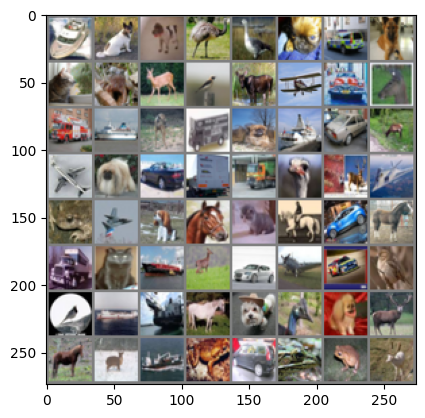

 ship   dog   dog  bird  bird   dog   car   dog   cat  frog  deer  bird  deer plane   car  deer truck  ship  deer truck   dog  ship   car  deer plane   dog   car truck truck  bird  deer plane


In [6]:
# Analisando o conjunto de imagens/rótulos CIFAR10
def imshow(img):
    img =img/2 + 0.5
    plt.imshow(np.transpose(img.numpy(),(1, 2,0)))
    plt.show()
images, labels =next(iter(trainloaders[0]))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

In [7]:
 # Carregando e Normalizando os Dados CIFAR10
  # Definindo as Transformações a serem aplicadas às imagens
def load_data():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = CIFAR10(root="./data", train=False, download=True, transform=transform)
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10 # 10% do conjunto para testes
        len_train = len(ds) - len_val
        lengths =[len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,num_workers=2))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,num_workers=2))
        testloader = DataLoader(testset,batch_size=BATCH_SIZE, shuffle=False,num_workers=2)
    return trainloaders, valloaders, testloader
    
trainloaders, valloaders, testloader = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Definindo o Modelo
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# Definindo as funções de treinamento
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [10]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.02861216163635254, accuracy 0.3704
Epoch 2: validation loss 0.026133902931213378, accuracy 0.412
Epoch 3: validation loss 0.024839704036712647, accuracy 0.4368
Epoch 4: validation loss 0.023993332290649413, accuracy 0.4544
Epoch 5: validation loss 0.02319503746032715, accuracy 0.4968
Final test set performance:
	loss 0.022511131179332733
	accuracy 0.4853
